# DL CNN project

In [1]:
import os
import math
import copy
import random as rand
import numpy as np
import cv2

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Lambda, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, Callback

from PIL import Image

from collections import Counter

from sklearn.metrics import classification_report, confusion_matrix

from google.colab import files
import uuid
import matplotlib.pyplot as plt

## Set up the Kaggle API

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


## Download the dataset

In [2]:
!kaggle datasets download "lakshaymiddha/crack-segmentation-dataset"
!unzip -q crack-segmentation-dataset.zip
!rm crack-segmentation-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/lakshaymiddha/crack-segmentation-dataset
License(s): unknown
100% 1.97G/1.98G [00:15<00:00, 117MB/s]
100% 1.98G/1.98G [00:15<00:00, 136MB/s]


## Dataset

In [8]:
# Paths
TRAIN_IMG_DIR = 'crack_segmentation_dataset/train/images'
TRAIN_MASK_DIR = 'crack_segmentation_dataset/train/masks'
TEST_IMG_DIR = 'crack_segmentation_dataset/test/images'
TEST_MASK_DIR = 'crack_segmentation_dataset/test/masks'

# Dataset Instance
class CrackSegmentationDatasetInstance:
    def __init__(self, filename, test=False):
        self.img_path = os.path.join(
            TEST_IMG_DIR if test else TRAIN_IMG_DIR, filename
        )
        self.is_crack = not filename.startswith('noncrack')
        self.mask_path = os.path.join(
            TEST_MASK_DIR if test else TRAIN_MASK_DIR, filename
        )

    def get_img(self):
        img = cv2.imread(self.img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img / 255.0
    def set_img(self,img):
        self.img = img

    def get_label(self):
        return int(self.is_crack)

    def get_mask(self):
        mask = cv2.imread(self.mask_path, cv2.IMREAD_GRAYSCALE)
        mask =  mask / 255.0
        return np.expand_dims(mask, axis=-1)

# Main Dataset
class CrackSegmentationDataset:
    def __init__(self):
        self.train_instances = [
            CrackSegmentationDatasetInstance(filename)
            for filename in os.listdir(TRAIN_IMG_DIR)
        ]
        self.test_instances = [
            CrackSegmentationDatasetInstance(filename, test=True)
            for filename in os.listdir(TEST_IMG_DIR)
        ]

    def _generator(self, instances, task='classification'):
        for instance in instances:
            img = instance.get_img()
            if task == 'classification':
                yield img, instance.get_label()
            elif task == 'segmentation':
                yield img, instance.get_mask()

    def get_dataset(self, split='train', batch_size=32, task='classification',stratified='false'):
      instances = (
          self.train_instances if split == 'train' else self.test_instances
      )

      dataset = tf.data.Dataset.from_generator(
        lambda: self._generator(instances, task),
        output_signature=(
          tf.TensorSpec(shape=(448, 448, 3), dtype=tf.float32),
          tf.TensorSpec(shape=(448, 448, 1), dtype=tf.float32) if task == 'segmentation' else tf.TensorSpec(shape=(), dtype=tf.int32),
        )
      )


      if split == 'test':
        if task == 'classification':
            return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        else:

            return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)



      train_size = int(0.9 * len(instances))
      train_ratio = 0.9
      val_size = len(instances) - train_size

      if not stratified:
        rand.shuffle(instances)
        train_instances = instances[:train_size]
        val_instances = instances[train_size:]
      else:
        crack = [ instance for instance in instances if instance.get_label()==1]
        non_crack = [instance for instance in instances if instance.get_label()==0]
        train_instances = crack[:int(train_ratio*(len(crack)))] + non_crack[:int(train_ratio*(len(non_crack)))]
        rand.shuffle(train_instances)
        val_instances = crack[:int(train_ratio*(len(crack)))] + non_crack[:int(train_ratio*(len(non_crack)))]
        rand.shuffle(val_instances)
      # Create the training and validation datasets
      train_ds = tf.data.Dataset.from_generator(
          lambda: self._generator(train_instances, task),
          output_signature=(
          tf.TensorSpec(shape=(448, 448, 3), dtype=tf.float32),
          tf.TensorSpec(shape=(448, 448, 1), dtype=tf.float32) if task == 'segmentation' else tf.TensorSpec(shape=(), dtype=tf.int32),
        )
      )

      val_ds = tf.data.Dataset.from_generator(
          lambda: self._generator(val_instances, task),
          output_signature=(
          tf.TensorSpec(shape=(448, 448, 3), dtype=tf.float32),
          tf.TensorSpec(shape=(448, 448, 1), dtype=tf.float32) if task == 'segmentation' else tf.TensorSpec(shape=(), dtype=tf.int32),
        )
      )

      train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
      val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

      return train_ds, val_ds



    def augment(self, augmentation_dir='crack_segmentation_dataset/train/images'):

        instances_crack = [instance for instance in self.train_instances if instance.get_label() == 1]
        instances_non_crack = [instance for instance in self.train_instances if instance.get_label() == 0]
        diff_instances = len(instances_crack) - len(instances_non_crack)
        display_count = 10

        display_counter = 0
        images_to_display = []

        for _ in range(diff_instances):
            rand_instance = rand.choice(instances_non_crack)
            new_img = rand_instance.get_img()

            height, width = new_img.shape[:2]


            fixed_angles = [90, 180, 270, -90, -180, -270]
            random_angle = rand.choice(fixed_angles)

            center = (width / 2, height / 2)
            rotation_matrix = cv2.getRotationMatrix2D(center, random_angle, scale=1.0)
            rotated_img = cv2.warpAffine(new_img, rotation_matrix, (width, height))

            width_ratio = rand.uniform(0.8, 1)
            height_ratio = width_ratio
            crop_width = int(width * width_ratio)
            crop_height = int(height * height_ratio)

            x_start = rand.randint(0, width - crop_width)
            y_start = rand.randint(0, height - crop_height)

            cropped_img = rotated_img[y_start:y_start + crop_height, x_start:x_start + crop_width]
            resized_img = cv2.resize(cropped_img, (width, height), interpolation=cv2.INTER_LINEAR)
            filename = os.path.join(augmentation_dir, f"noncrack_{uuid.uuid4()}.jpg")
            cv2.imwrite(filename, (resized_img * 255).astype('uint8'))
            new_instance = CrackSegmentationDatasetInstance(filename, test=False)
            self.train_instances.append(new_instance)
            if display_counter < display_count:
              images_to_display.append(resized_img)
              display_counter += 1
        rand.shuffle(self.train_instances)
        # stacked_images = cv2.vconcat(images_to_display)
        # plt.figure(figsize=(10, 5))
        # plt.imshow(stacked_images, cmap='gray' if len(stacked_images.shape) == 2 else None)
        # plt.axis('off')
        # plt.show()

### Dataset creation

In [4]:
dataset = CrackSegmentationDataset()

## Dataset analysis

In [5]:
counter = Counter(instance.get_label() for instance in dataset.train_instances)

print(f"Number of non-crack images: {counter[0]}")
print(f"Number of crack images: {counter[1]}")

Number of non-crack images: 1199
Number of crack images: 8404


# The exercise fo grade 3.0

## Basic classification

Here we created a very simple model, with convolution, pooling and dense layer with relu activation function, as we expected the basic task shall not be too sophisticated and such light network could deal with it.
To trace the performance of our model while training, and to be able to use all kind of earlystopping, leave-plateau methods, we further splitted the test set into test set and validation set. in proportion 9/1

In [6]:

epoch_early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

train_ds,val_ds = dataset.get_dataset(split='train', batch_size=32, task='classification')
test_ds = dataset.get_dataset(split='test', batch_size=32, task='classification')

classification_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(448, 448, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

classification_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
classification_model.fit(train_ds, validation_data=val_ds,callbacks=[epoch_early_stopping], epochs=10)

Epoch 1/10
    271/Unknown 71s 226ms/step - accuracy: 0.8156 - loss: 11.7745

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


271/271 ━━━━━━━━━━━━━━━━━━━━ 156s 543ms/step - accuracy: 0.8158 - loss: 11.7434 - val_accuracy: 0.8776 - val_loss: 0.2809
Epoch 2/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 128s 472ms/step - accuracy: 0.8781 - loss: 0.2848 - val_accuracy: 0.9029 - val_loss: 0.2128
Epoch 3/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 111s 410ms/step - accuracy: 0.9019 - loss: 0.2712 - val_accuracy: 0.9278 - val_loss: 0.1880
Epoch 4/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 109s 404ms/step - accuracy: 0.9296 - loss: 0.1494 - val_accuracy: 0.9439 - val_loss: 0.1569
Epoch 5/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 140s 518ms/step - accuracy: 0.9447 - loss: 0.1221 - val_accuracy: 0.9567 - val_loss: 0.1039
Epoch 6/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 110s 404ms/step - accuracy: 0.9536 - loss: 0.1138 - val_accuracy: 0.9558 - val_loss: 0.1700
Epoch 7/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 141s 521ms/step - accuracy: 0.9471 - loss: 0.1422 - val_accuracy: 0.9710 - val_loss: 0.0708
Epoch 8/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 109s 402ms/step - accuracy: 0.9743 - loss: 0.0

### Evaluation  on the test set

In [7]:
loss, accuracy = classification_model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
y_true = []
y_pred = []
for images, labels in test_ds:
    predictions = classification_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend((predictions > 0.5).astype(int).flatten())
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Non-Crack", "Crack"]))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 277ms/step - accuracy: 0.9029 - loss: 0.4872
Test Loss: 0.4619
Test Accuracy: 0.9015
Classification Report:
              precision    recall  f1-score   support

   Non-Crack       0.65      0.45      0.53       212
       Crack       0.93      0.97      0.94      1483

    accuracy                           0.90      1695
   macro avg       0.79      0.71      0.74      1695
weighted avg       0.89      0.90      0.89      1695

Confusion Matrix:
[[  96  116]
 [  51 1432]]


### conclusions
As we see the performance of the model on the training and validation data was impeccable. the result on the test set was not that stunning however. It stems from the extreme overfitt of the model to the training data , as seen the recall on the crack in the test set was extremly poor, what forces as to address this issue. Also the validation set and training set in this case were taken on random, not stratified, what could also lead to non-representative result.

### Imbalanced data
As we have discovered earlier the data set is highly imbalanced with 8 times more crack images than non crack images in the training set. This make it difficult for the model and we need to find a way to cope with it
- first approach is to use a specifically tailored loss function for the imbalanced data. In this case we can explore a variation of the binary cross-entropy a binary focal crossentropy. this variation of crossentropy that accounts for 'difficulty' of examples . Since due to imbalance in training data, the non-crack examples are far more difficult to properly classify, this loss function is paying more attention to misclassified examples = non-crack examples, it is a boosting approach.
- second  approach, we can augment the non-crack images eg artificialy create more of the examples of this class. to do so we can freely rotate them by some multiplicity of 90 degrees(to avoid having padding) and zoom, it shall produce completly valid non-crack images

### weighted cross-entropy

As mentioned earlier, to leverage all of the data, but without the need of augmentation but still addressing the issue of the  data imbalance we can adjust our loss function to a tweaked version of binary cross entropy. This version will use  boosting on the non-crack  examples, as it accounts for the class imbalance in the training ( non crack being more difficult to classify trerefore mistake on them is penalized more in this loss function)







In [ ]:
epoch_early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

train_ds,val_ds = dataset.get_dataset(split='train', batch_size=32, task='classification')


classification_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(448, 448, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

classification_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryFocalCrossentropy(
    apply_class_balancing=False,
    alpha=0.25,
    gamma=2.0,
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='sum_over_batch_size',
    name='binary_focal_crossentropy'
),
    metrics=['accuracy']
)


classification_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[epoch_early_stopping],
    verbose=1
)

Epoch 1/10
    241/Unknown 56s 216ms/step - accuracy: 0.7983 - loss: 4.9419

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


241/241 ━━━━━━━━━━━━━━━━━━━━ 71s 281ms/step - accuracy: 0.7985 - loss: 4.9266 - val_accuracy: 0.9183 - val_loss: 0.0701
Epoch 2/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 73s 304ms/step - accuracy: 0.9370 - loss: 0.0542 - val_accuracy: 0.9328 - val_loss: 0.0548
Epoch 3/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 85s 315ms/step - accuracy: 0.9427 - loss: 0.0446 - val_accuracy: 0.9131 - val_loss: 0.0845
Epoch 4/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 73s 280ms/step - accuracy: 0.9553 - loss: 0.0337 - val_accuracy: 0.9521 - val_loss: 0.0559
Epoch 5/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 68s 282ms/step - accuracy: 0.9619 - loss: 0.0333 - val_accuracy: 0.9500 - val_loss: 0.0609
Epoch 6/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 63s 262ms/step - accuracy: 0.9703 - loss: 0.0266 - val_accuracy: 0.9167 - val_loss: 0.1120
Epoch 7/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 64s 267ms/step - accuracy: 0.9685 - loss: 0.0220 - val_accuracy: 0.9490 - val_loss: 0.0792


In [ ]:
# Evaluate the model on the test dataset
test_ds = dataset.get_test_dataset(split='test', batch_size=32, task='classification')
loss, accuracy = classification_model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Compute additional metrics
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = classification_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend((predictions > 0.5).astype(int).flatten())

# Generate classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Non-Crack", "Crack"]))

# Generate confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 255ms/step - accuracy: 0.9409 - loss: 0.0532
Test Loss: 0.0503
Test Accuracy: 0.9463
Classification Report:
              precision    recall  f1-score   support

   Non-Crack       0.80      0.75      0.78       212
       Crack       0.97      0.97      0.97      1483

    accuracy                           0.95      1695
   macro avg       0.88      0.86      0.87      1695
weighted avg       0.95      0.95      0.95      1695

Confusion Matrix:
[[ 160   52]
 [  39 1444]]


### Conclusions
The overall precision is the best so far, but more importantly, this network improved the handling of non crack case, it improved  recall on these cases and precision, the network is handling the non crack cases better.

### Data augmentation
here we utilize the data augmentation techinque creating artificial non -crack examples to balance the test set. The creation of examples consists of picking on random, non-crack examples, rotating them -  by the multiplicity of 90 degrees, to prevent the issue of not fitting in the frame and  creation of padding, and  later the images are arbitrarly zoomed to bring more variety to the dataset and not just duplicate examples. The loss function utilized is the focal binary crossentropy seems it proved better than normal binary cross_entropy. Several augmented images are shown below to see that , the augmentation produced valid instances of non-crack images.


In [10]:
epoch_early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

''' the augmentaing part '''
# dataset.augment()
dataset = CrackSegmentationDataset()
counter = Counter(instance.get_label() for instance in dataset.train_instances)
print(f"Number of non-crack images: {counter[0]}")
print(f"Number of crack images: {counter[1]}")

train_ds, val_ds = dataset.get_dataset(split='train', batch_size=32, task='classification')

classification_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(448, 448, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

classification_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


classification_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[epoch_early_stopping],
    verbose=1
)

Number of non-crack images: 8404
Number of crack images: 8404
Epoch 1/10
    473/Unknown 101s 210ms/step - accuracy: 0.7820 - loss: 10.3672

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


473/473 ━━━━━━━━━━━━━━━━━━━━ 190s 399ms/step - accuracy: 0.7821 - loss: 10.3508 - val_accuracy: 0.9063 - val_loss: 0.2485
Epoch 2/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 239s 506ms/step - accuracy: 0.9101 - loss: 0.2228 - val_accuracy: 0.9513 - val_loss: 0.1457
Epoch 3/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 182s 384ms/step - accuracy: 0.9383 - loss: 0.1580 - val_accuracy: 0.9483 - val_loss: 0.1801
Epoch 4/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 240s 508ms/step - accuracy: 0.9395 - loss: 0.1739 - val_accuracy: 0.9662 - val_loss: 0.1120
Epoch 5/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 187s 395ms/step - accuracy: 0.9546 - loss: 0.1259 - val_accuracy: 0.9755 - val_loss: 0.0720
Epoch 6/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 202s 394ms/step - accuracy: 0.9702 - loss: 0.0914 - val_accuracy: 0.9238 - val_loss: 0.1906
Epoch 7/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 179s 378ms/step - accuracy: 0.9684 - loss: 0.1049 - val_accuracy: 0.9641 - val_loss: 0.1067
Epoch 8/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 205s 386ms/step - accuracy: 0.9767 - loss: 0.0

In [ ]:
# Evaluate the model on the test dataset
test_ds = dataset.get_dataset(split='test', batch_size=32, task='classification')
loss, accuracy = classification_model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Compute additional metrics
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = classification_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend((predictions > 0.5).astype(int).flatten())

# Generate classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Non-Crack", "Crack"]))

# Generate confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 200ms/step - accuracy: 0.9167 - loss: 0.0727
Test Loss: 0.0664
Test Accuracy: 0.9180
Classification Report:
              precision    recall  f1-score   support

   Non-Crack       0.63      0.82      0.71       212
       Crack       0.97      0.93      0.95      1483

    accuracy                           0.92      1695
   macro avg       0.80      0.88      0.83      1695
weighted avg       0.93      0.92      0.92      1695

Confusion Matrix:
[[ 174   38]
 [ 101 1382]]


### conclusions
surprisingly the augmentation of data did not bring the improvement in the accuracy or f1 scores for both classes, it seems it has overfitted to the training set as it was receiving very high accuracy there, but worse on test set. It was however receiving very high accuracy on the validation set , but it may also be cause that the fact that validation set consisted of the augmented images as well, so the model somehow overfitted to this. As expected it increased the recall of the non-crack class, but on the other hand decreased it's precision what is not favourbale but could also be expected, overall the model not utilizing the data augmentation proved to perform better on the test set. Maybe the data augmentation shall be performed with more variety of rotation, but this would be more complicated not to create any padding, as an artifical padding could be an element on whoch model would accidently learn.

### Unet model
Here the unet model is defined, it is a this defualt unet architecture
- however the number of channel is a parameter , one can choose the number of channels for the first convolution and every next encoder layer  will have 2 as much till the bottelneck - it will have 16 times this number of channels. And then the decoder layers, decreasing number of channels and increasing spatial resolution.
- As the last layer of the network we have choosen the sigmoid layer which maps  to each pixels the value outputed by the last layer sigmoid - in case of segmentation, and one value outputed by the sigmoid, in case of classification. If the value > 0.5 than the predicted class is crack, else non-crack

In [ ]:
'''with the batch normalization'''
def unet_model(input_shape,filter_number=32,segmentation=True):
    inputs = Input(shape=input_shape)

    # Layer converting the picture into grayscale
    lambda_layer = Lambda(lambda x: (0.21 * x[..., :1]) + (0.72 * x[..., 1:2]) + (0.07 * x[..., -1:]))(inputs)

    # Encoder phase, downsampling of the picture
    d1 = Conv2D(filter_number, (3, 3), padding='same')(lambda_layer)
    d1 = BatchNormalization()(d1)
    d1 = Activation('relu')(d1)
    d1 = Conv2D(filter_number, (3, 3), padding='same')(d1)
    d1 = BatchNormalization()(d1)
    d1 = Activation('relu')(d1)
    p1 = MaxPooling2D((2, 2))(d1)

    d2 = Conv2D(filter_number*2, (3, 3), padding='same')(p1)
    d2 = BatchNormalization()(d2)
    d2 = Activation('relu')(d2)
    d2 = Conv2D(filter_number*2, (3, 3), padding='same')(d2)
    d2 = BatchNormalization()(d2)
    d2 = Activation('relu')(d2)
    p2 = MaxPooling2D((2, 2))(d2)

    d3 = Conv2D(filter_number*4, (3, 3), padding='same')(p2)
    d3 = BatchNormalization()(d3)
    d3 = Activation('relu')(d3)
    d3 = Conv2D(filter_number*4, (3, 3), padding='same')(d3)
    d3 = BatchNormalization()(d3)
    d3 = Activation('relu')(d3)
    p3 = MaxPooling2D((2, 2))(d3)

    d4 = Conv2D(filter_number*8, (3, 3), padding='same')(p3)
    d4 = BatchNormalization()(d4)
    d4 = Activation('relu')(d4)
    d4 = Conv2D(filter_number*8, (3, 3), padding='same')(d4)
    d4 = BatchNormalization()(d4)
    d4 = Activation('relu')(d4)

    # Bottleneck
    b = MaxPooling2D((2, 2))(d4)
    b = Conv2D(filter_number*16, (3, 3), padding='same')(b)
    b = BatchNormalization()(b)
    b = Activation('relu')(b)
    b = Conv2D(filter_number*16, (3, 3), padding='same')(b)
    b = BatchNormalization()(b)
    b = Activation('relu')(b)

    # Decoder phase, upsampling of the picture
    u1 = Conv2DTranspose(filter_number*8, (2, 2), strides=(2, 2), padding='same')(b)
    u1 = concatenate([u1, d4])  # Skip connection
    u1 = Conv2D(filter_number*8, (3, 3), padding='same')(u1)
    u1 = BatchNormalization()(u1)
    u1 = Activation('relu')(u1)
    u1 = Conv2D(filter_number*8, (3, 3), padding='same')(u1)
    u1 = BatchNormalization()(u1)
    u1 = Activation('relu')(u1)

    u2 = Conv2DTranspose(filter_number*4, (2, 2), strides=(2, 2), padding='same')(u1)
    u2 = concatenate([u2, d3])  # Skip connection
    u2 = Conv2D(filter_number*4, (3, 3), padding='same')(u2)
    u2 = BatchNormalization()(u2)
    u2 = Activation('relu')(u2)
    u2 = Conv2D(filter_number*4, (3, 3), padding='same')(u2)
    u2 = BatchNormalization()(u2)
    u2 = Activation('relu')(u2)

    u3 = Conv2DTranspose(filter_number*2, (2, 2), strides=(2, 2), padding='same')(u2)
    u3 = concatenate([u3, d2])  # Skip connection
    u3 = Conv2D(filter_number*2, (3, 3), padding='same')(u3)
    u3 = BatchNormalization()(u3)
    u3 = Activation('relu')(u3)
    u3 = Conv2D(filter_number*2, (3, 3), padding='same')(u3)
    u3 = BatchNormalization()(u3)
    u3 = Activation('relu')(u3)

    u4 = Conv2DTranspose(filter_number, (2, 2), strides=(2, 2), padding='same')(u3)
    u4 = concatenate([u4, d1])  # Skip connection
    u4 = Conv2D(filter_number, (3, 3), padding='same')(u4)
    u4 = BatchNormalization()(u4)
    u4 = Activation('relu')(u4)
    u4 = Conv2D(filter_number, (3, 3), padding='same')(u4)
    u4 = BatchNormalization()(u4)
    u4 = Activation('relu')(u4)


    if not segmentation:
      gap = GlobalAveragePooling2D()(u4)  # This layer reduces the spatial dimensions (height, width) to a scalar

      output = tf.keras.layers.Dense(1, activation='sigmoid')(gap)  # A single output for the whole image, with a sigmoid activation
      model = tf.keras.Model(inputs=[inputs], outputs=[output])
      return model

    else:
      outputs = Conv2D(1, (1, 1), activation='sigmoid')(u4)
      model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
      return model


'''seeing the model parametrs'''
mod = unet_model(input_shape=(448, 448, 3),filter_number=16,segmentation=True)
mod.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 448, 448, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 448, 448, 1)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 448, 448, 16)   │            160 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 448, 448, 16)   │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 448, 448, 16)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 448, 448, 16)   │          2,320 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 448, 448, 16)   │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 448, 448, 16)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 224, 224, 16)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 224, 224, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 224, 224, 32)   │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 224, 224, 32)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 224, 224, 32)   │          9,248 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 224, 224, 32)   │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 224, 224, 32)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 112, 112, 32)   │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)    

 Total params: 1,946,705 (7.43 MB)

 Trainable params: 1,943,761 (7.41 MB)

 Non-trainable params: 2,944 (11.50 KB)

### Unet++ model
an improved Unet model. It differs from the Unetas it provides more skip connections, basically each decoder is connected not only with encoder on its level but with every encoder of same/deeper level than it, ensuring even better gloal feature extraction

In [ ]:
def unet_plus_plus(input_shape,filter_number=32, deep_supervision=False):
    inputs = Input(shape=input_shape)

    # Layer converting the picture into grayscale
    lambda_layer = Lambda(lambda x: (0.21 * x[..., :1]) + (0.72 * x[..., 1:2]) + (0.07 * x[..., -1:]))(inputs)

    # Encoder phase, downsampling of the picture
    d1 = Conv2D(filter_number, (3, 3), padding='same')(lambda_layer)
    d1 = BatchNormalization()(d1)
    d1 = Activation('relu')(d1)
    d1 = Conv2D(filter_number, (3, 3), padding='same')(d1)
    d1 = BatchNormalization()(d1)
    d1 = Activation('relu')(d1)
    p1 = MaxPooling2D((2, 2))(d1)

    d2 = Conv2D(2*filter_number, (3, 3), padding='same')(p1)
    d2 = BatchNormalization()(d2)
    d2 = Activation('relu')(d2)
    d2 = Conv2D(2*filter_number, (3, 3), padding='same')(d2)
    d2 = BatchNormalization()(d2)
    d2 = Activation('relu')(d2)
    p2 = MaxPooling2D((2, 2))(d2)

    d3 = Conv2D(4*filter_number, (3, 3), padding='same')(p2)
    d3 = BatchNormalization()(d3)
    d3 = Activation('relu')(d3)
    d3 = Conv2D(4*filter_number, (3, 3), padding='same')(d3)
    d3 = BatchNormalization()(d3)
    d3 = Activation('relu')(d3)
    p3 = MaxPooling2D((2, 2))(d3)

    d4 = Conv2D(8*filter_number, (3, 3), padding='same')(p3)
    d4 = BatchNormalization()(d4)
    d4 = Activation('relu')(d4)
    d4 = Conv2D(8*filter_number, (3, 3), padding='same')(d4)
    d4 = BatchNormalization()(d4)
    d4 = Activation('relu')(d4)
    p4 = MaxPooling2D((2, 2))(d4)

    d5 = Conv2D(16*filter_number, (3, 3), padding='same')(p4)
    d5 = BatchNormalization()(d5)
    d5 = Activation('relu')(d5)
    d5 = Conv2D(16*filter_number, (3, 3), padding='same')(d5)
    d5 = BatchNormalization()(d5)
    d5 = Activation('relu')(d5)

    # Decoder phase with Batch Normalization and deep supervision
    def decoder_block(up_input, skip_input, filters):
        up = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(up_input)
        up = concatenate([up, skip_input])
        up = Conv2D(filters, (3, 3), padding='same')(up)
        up = BatchNormalization()(up)
        up = Activation('relu')(up)
        up = Conv2D(filters, (3, 3), padding='same')(up)
        up = BatchNormalization()(up)
        up = Activation('relu')(up)
        return up

    # the first horizontal layer
    u_01 = decoder_block(d2, d1, filter_number)
    u_11 = decoder_block(d3, d2, filter_number*2)
    u_21 = decoder_block(d4, d3, filter_number*4)
    u_31 = decoder_block(d5, d4, filter_number*8)

    #second horizontal layer
    u_02 = decoder_block(u_11, u_01, filter_number)
    u_12 = decoder_block(u_21, u_11, filter_number*2)
    u_22 = decoder_block(u_31, u_21, filter_number*4)

    #third horizontal layer
    u_03 = decoder_block(u_12, u_02, filter_number)
    u_13 = decoder_block(u_22, u_12, filter_number*2)

    #last horizontal layer
    u_04 = decoder_block(u_13, u_03, filter_number)

    # deep supervision possibility that we do not utilize anyway
    if deep_supervision:
        outputs = [
            Lambda(lambda x: tf.cast(tf.greater(x[..., 1], x[..., 0]), tf.float32))(
                tf.keras.layers.Conv2D(2, (1, 1), activation='sigmoid')(u_01)),
            Lambda(lambda x: tf.cast(tf.greater(x[..., 1], x[..., 0]), tf.float32))(
                tf.keras.layers.Conv2D(2, (1, 1), activation='sigmoid')(u_02)),
            Lambda(lambda x: tf.cast(tf.greater(x[..., 1], x[..., 0]), tf.float32))(
                tf.keras.layers.Conv2D(2, (1, 1), activation='sigmoid')(u_03)),
            Lambda(lambda x: tf.cast(tf.greater(x[..., 1], x[..., 0]), tf.float32))(
                tf.keras.layers.Conv2D(2, (1, 1), activation='sigmoid')(u_04))
        ]
        model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
        return model

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(u_04)
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model


### The unet model for classification

usually the unet model is used for the semantic segmentation, but here we will try utylizing it for the purpose of classification.

In [ ]:
epoch_early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

train_ds,val_ds = dataset.get_dataset(split='train', batch_size=8, task='classification')


classification_model = unet_model(input_shape=(448, 448, 3),filter_number=16,segmentation=False)
classification_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryFocalCrossentropy(
    apply_class_balancing=False,
    alpha=0.25,
    gamma=2.0,
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='sum_over_batch_size',
    name='binary_focal_crossentropy'
),
    metrics=['accuracy']
)

classification_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[epoch_early_stopping],

    verbose=1
)

In [ ]:
# Evaluate the model on the test dataset
test_ds = dataset.get_test_dataset(split='test', batch_size=32, task='classification')
loss, accuracy = classification_model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Compute additional metrics
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = classification_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend((predictions > 0.5).astype(int).flatten())

# Generate classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Non-Crack", "Crack"]))

# Generate confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

53/53 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.9257 - loss: 0.0277
Test Loss: 0.0301
Test Accuracy: 0.9198
Classification Report:
              precision    recall  f1-score   support

   Non-Crack       0.70      0.62      0.66       212
       Crack       0.95      0.96      0.95      1483

    accuracy                           0.92      1695
   macro avg       0.83      0.79      0.81      1695
weighted avg       0.92      0.92      0.92      1695

Confusion Matrix:
[[ 131   81]
 [  55 1428]]


### conclusions

It didnt perform bad, but it was worse than the  earlier simpler model, likely because it is not the perfect architecture for classification

# task 4.0 Semantic segmentation
Here the semantic segmentation will take place, firstly we will try the unet model and unet++ models trained from scratch .



#### Loss functions for the semantic segmentation

In [ ]:
'''dice loss, the go to loss function for the semantic segmentation, especially with such imabalnced classes'''
def dice_loss(smooth=1):
    def dice_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        y_true_f = tf.reshape(y_true, [-1])
        y_pred_f = tf.reshape(y_pred, [-1])
        intersection = tf.reduce_sum(y_true_f * y_pred_f)
        dice_coeff = (2. * intersection + smooth) / (
            tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
        )
        return 1 - dice_coeff
    return dice_loss_fixed

'''good loss function for the imbalanced data, however very difficult to utilize since determining the good alpha parameter value
is not easy, probably some hyperparameter tunning would be necessary'''
def focal_loss(gamma=2., alpha=0.9):

    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        pt_1 = tf.where(K.equal(y_true, 1), y_pred, K.ones_like(y_pred))
        pt_0 = tf.where(K.equal(y_true, 0), 1 - y_pred, K.ones_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - \
               K.sum((1 - alpha) * K.pow(1. - pt_0, gamma) * K.log(pt_0))
    return focal_loss_fixed



'''usefull metrics defined to determine the semantic segmentation performance of network '''
def crack_precision(y_true, y_pred):
    y_pred_bin = K.cast(K.greater(y_pred, 0.5), K.floatx())
    TP = K.sum(y_true * y_pred_bin)
    FP = K.sum((1 - y_true) * y_pred_bin)
    precision = TP / (TP + FP + K.epsilon())
    return precision

def crack_recall(y_true, y_pred):
    y_pred_bin = K.cast(K.greater(y_pred, 0.5), K.floatx())
    TP = K.sum(y_true * y_pred_bin)
    FN = K.sum(y_true * (1 - y_pred_bin))
    recall = TP / (TP + FN + K.epsilon())
    return recall

def non_crack_recall(y_true, y_pred):
    y_pred_bin = K.cast(K.greater(y_pred, 0.5), K.floatx())
    TN = K.sum((1 - y_true) * (1 - y_pred_bin))
    FP = K.sum((1-y_true) * y_pred_bin)
    recall = TN / (TN + FP + K.epsilon())
    return recall

def non_crack_precision(y_true, y_pred):
    y_pred_bin = K.cast(K.greater(y_pred, 0.5), K.floatx())
    TN = K.sum((1 - y_true) * (1 - y_pred_bin))
    FN = K.sum(y_true * (1-y_pred_bin))
    precision = TN / (TN + FN + K.epsilon())
    return precision

### Testing the unet semantic segmentation

We will start by examining different loss function, firstly we will start with the focal loss we set the gamma for 2, to quadraticaly scale the penalties for the wrong prediction, and we utilize alpha 0.9 meaning ommiting a crack is 9 times more expensive than prediction crack where it should not be, we do the second point to compensate for the very high class imbalance

In [ ]:
epoch_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

train_ds,val_ds = dataset.get_dataset(split='train', batch_size=16, task='segmentation',stratified=False)

segmentation_model = unet_model(input_shape=(448, 448, 3), filter_number=8, segmentation='True')
segmentation_model.compile(
    optimizer='adam',
    loss=focal_loss(),
    metrics=[crack_precision, crack_recall,non_crack_precision,non_crack_recall]
)
segmentation_model.fit(train_ds, validation_data=val_ds,callbacks=[epoch_early_stopping], epochs=10)

Epoch 1/10
     35/Unknown 70s 409ms/step - crack_precision: 0.0990 - crack_recall: 0.5657 - loss: 68597.7969 - non_crack_precision: 0.9772 - non_crack_recall: 0.7075

KeyboardInterrupt: 

### Dice loss
here we switch to the dice loss, in order to etermine which one shows more promising results, and is worth further exploration and combining with change of other different parameters

In [ ]:
epoch_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True )

train_ds,val_ds = dataset.get_dataset(split='train', batch_size=16, task='segmentation',stratified=True)

segmentation_model = unet_model(input_shape=(448, 448, 3), filter_number=8, segmentation='True')
segmentation_model.compile(
    optimizer='adam',
    loss=dice_loss(),
    metrics=[crack_precision, crack_recall,non_crack_precision,non_crack_recall]
)
segmentation_model.fit(train_ds, validation_data=val_ds,callbacks=[epoch_early_stopping], epochs=15)

Epoch 1/15
    541/Unknown 193s 260ms/step - crack_precision: 0.2509 - crack_recall: 0.7575 - loss: 0.7694 - non_crack_precision: 0.9883 - non_crack_recall: 0.8277

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


541/541 ━━━━━━━━━━━━━━━━━━━━ 260s 384ms/step - crack_precision: 0.2512 - crack_recall: 0.7574 - loss: 0.7691 - non_crack_precision: 0.9883 - non_crack_recall: 0.8278 - val_crack_precision: 0.6775 - val_crack_recall: 0.2680 - val_loss: 0.6469 - val_non_crack_precision: 0.9737 - val_non_crack_recall: 0.9956
Epoch 2/15
541/541 ━━━━━━━━━━━━━━━━━━━━ 191s 353ms/step - crack_precision: 0.5955 - crack_recall: 0.6603 - loss: 0.4014 - non_crack_precision: 0.9874 - non_crack_recall: 0.9841 - val_crack_precision: 0.6570 - val_crack_recall: 0.6167 - val_loss: 0.3748 - val_non_crack_precision: 0.9861 - val_non_crack_recall: 0.9886
Epoch 3/15
541/541 ━━━━━━━━━━━━━━━━━━━━ 208s 385ms/step - crack_precision: 0.6330 - crack_recall: 0.6707 - loss: 0.3599 - non_crack_precision: 0.9878 - non_crack_recall: 0.9864 - val_crack_precision: 0.6103 - val_crack_recall: 0.6780 - val_loss: 0.3644 - val_non_crack_precision: 0.9883 - val_non_crack_recall: 0.9844
Epoch 4/15
541/541 ━━━━━━━━━━━━━━━━━━━━ 192s 354ms/step -

### conclusions

It turns out the dice loss proved to have performed better, thus we will focus on exploring the model learning on this loss function

### displaying the predictions,
the raw metrics like recall and precision of 0 and 1 class  are informative no doubt , however to the human eye, it is always additional value to have a good visualization of the outcomes of experiments. In this case having such is not a very challenging task, we will choose n random image form the test set, and visualize the model prediction on them.

In [ ]:
def display_predictions(model, dataset, n=5, verbose=1):
    test_data = list(dataset)

    if len(test_data) == 0:
        raise ValueError("The test dataset is empty.")
    selected_samples = rand.sample(test_data, n)
    plt.figure(figsize=(20, 5 * n))
    for idx, (img_batch, mask_batch) in enumerate(selected_samples):
        for img, expected_mask in zip(img_batch.numpy(), mask_batch.numpy()):
            predicted_mask = model.predict(img[np.newaxis, ...], verbose=verbose)[0]
            binarized_mask = (predicted_mask > 0.5).astype(float)
            plt.subplot(n, 4, 4 * idx + 1)
            plt.imshow(img)
            plt.title("Original Image")
            plt.axis('off')
            plt.subplot(n, 4, 4 * idx + 2)
            plt.imshow(expected_mask.squeeze(), cmap='gray')
            plt.title("Expected Mask")
            plt.axis('off')
            plt.subplot(n, 4, 4 * idx + 3)
            plt.imshow(predicted_mask.squeeze(), cmap='gray')
            plt.title("Predicted Mask")
            plt.axis('off')
            plt.subplot(n, 4, 4 * idx + 4)
            plt.imshow(binarized_mask.squeeze(), cmap='gray')
            plt.title("Binarized Mask")
            plt.axis('off')
    plt.tight_layout()
    plt.show()

### Metric calculation and visualization of the model performance

1695/1695 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - crack_precision: 0.5632 - crack_recall: 0.6198 - loss: 0.3852 - non_crack_precision: 0.9898 - non_crack_recall: 0.9872
Test Loss: 0.3747
Test crack Precision: 0.5551
Test crack Recall: 0.6231
Test non-crack Precision: 0.9901
Test non-crack Recall: 0.9867
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


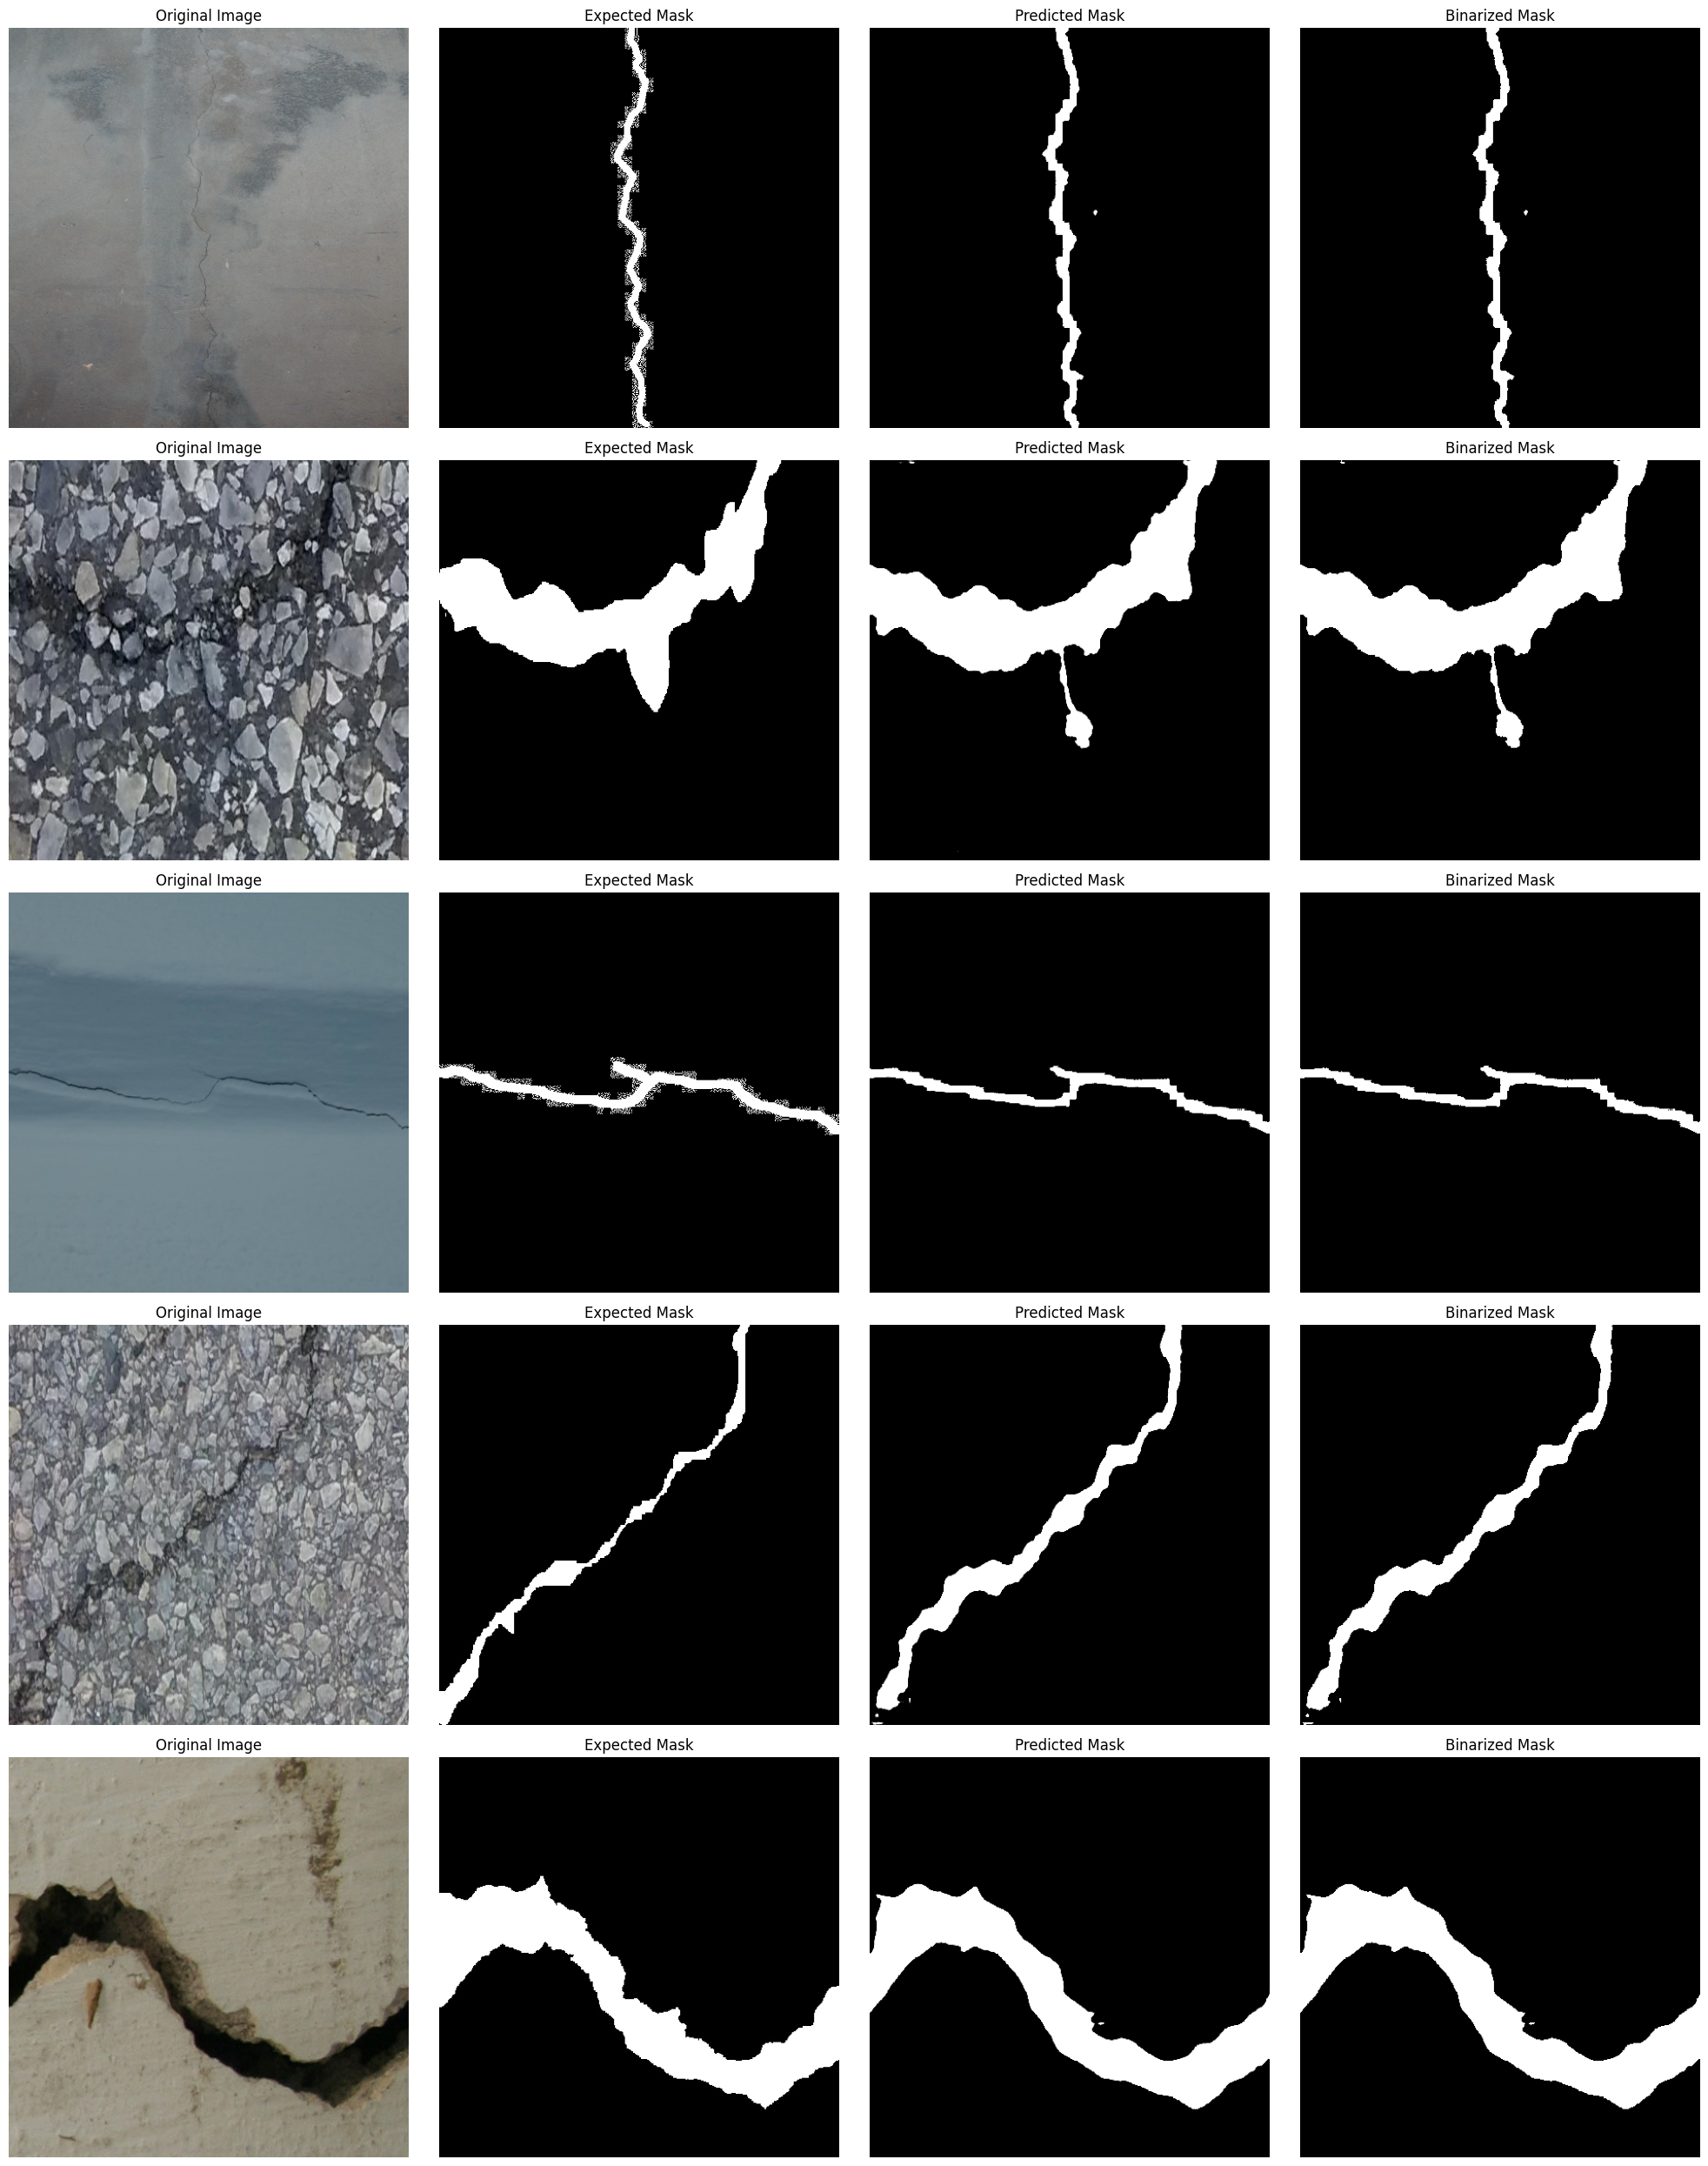

In [ ]:
test_ds = dataset.get_dataset(split='test', batch_size=1, task='segmentation')
loss, crack_precision, crack_recall,non_crack_precision,non_crack_recall = segmentation_model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test crack Precision: {crack_precision:.4f}")
print(f"Test crack Recall: {crack_recall:.4f}")
print(f"Test non-crack Precision: {non_crack_precision:.4f}")
print(f"Test non-crack Recall: {non_crack_recall:.4f}")
display_predictions(segmentation_model, test_ds, n=5)

### channel number adjustment

As mentioned earlier, our implementation of the unet network allows for the choice of the channel number in each convolutional layer, when the better loss function is dtermined we can , try to use a bigger network, starting with 16 channels in the first convolutional layer

In [ ]:
epoch_early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

train_ds,val_ds = dataset.get_dataset(split='train', batch_size=16, task='segmentation',stratified=True)

segmentation_model = unet_model(input_shape=(448, 448, 3),filter_number=16)
segmentation_model.compile(
    optimizer='adam',
    loss=focal_loss(),
    metrics=[crack_precision, crack_recall,non_crack_precision,non_crack_recall]
)
segmentation_model.fit(train_ds, validation_data=val_ds,callbacks=[epoch_early_stopping], epochs=10)

Epoch 1/10
   1681/Unknown 422s 224ms/step - accuracy: 0.9524 - loss: 193411.2656

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1681/1681 ━━━━━━━━━━━━━━━━━━━━ 524s 285ms/step - accuracy: 0.9524 - loss: 193399.8281 - val_accuracy: 0.9526 - val_loss: 170244.3438
Epoch 2/10
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 450s 268ms/step - accuracy: 0.9524 - loss: 170412.7656 - val_accuracy: 0.9526 - val_loss: 170244.6875
Epoch 3/10
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 500s 266ms/step - accuracy: 0.9524 - loss: 170348.5625 - val_accuracy: 0.9526 - val_loss: 170725.5781
Epoch 4/10
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 502s 267ms/step - accuracy: 0.9524 - loss: 170309.3594 - val_accuracy: 0.9526 - val_loss: 170083.0156


In [ ]:
test_ds = dataset.get_dataset(split='test', batch_size=1, task='segmentation')
loss, crack_precision, crack_recall,non_crack_precision,non_crack_recall = segmentation_model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test crack Precision: {crack_precision:.4f}")
print(f"Test crack Recall: {crack_recall:.4f}")
print(f"Test non-crack Precision: {non_crack_precision:.4f}")
print(f"Test non-crack Recall: {non_crack_recall:.4f}")
display_predictions(segmentation_model, test_ds, n=5)

ValueError: Cannot take the length of shape with unknown rank.

### Model exchange
here we will check performance of the unet++ model, similar however more sophisticated model, we will run it on earlier determined best parameters

In [ ]:
epoch_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

train_ds,val_ds = dataset.get_dataset(split='train', batch_size=16, task='segmentation',stratified=True)

segmentation_model = unet_plus_plus(input_shape=(448, 448, 3), filter_number=8)
segmentation_model.compile(
    optimizer='adam',
    loss=dice_loss(),
    metrics=[crack_precision, crack_recall,non_crack_precision,non_crack_recall]
)
segmentation_model.fit(train_ds, validation_data=val_ds,callbacks=[epoch_early_stopping], epochs=15)

### conclusions


# Task for 5

# Grad-CAM for segmentation without mask provided during training
So here we are faced with a task of semantic segmentation of cracks, however during the training we are only allowed to use the information whether given image contains crack or not.
- our idea to solve this task is implementing the grad -cam . The idea behind the grad-cam is to trace   the back propagation of the loss gradient in the network in order to determine which channels - in consequences pixels, contributed the most to the given final class prediction. in case our classification model labelled given example as crack - We check which pixels had the biggest positive gradient, i.e contributed the most to the class 1  and then we visualize them on the heatmap. In case our model predicted class 0 , we just return the backgorund mask

In [ ]:
'''we utilize our earlier classification model from the exercise for 3 '''
epoch_early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

train_ds,val_ds = dataset.get_dataset(split='train', batch_size=32, task='classification')
classification_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(448, 448, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

classification_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryFocalCrossentropy(
    apply_class_balancing=False,
    alpha=0.25,
    gamma=2.0,
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='sum_over_batch_size',
    name='binary_focal_crossentropy'
),
    metrics=['accuracy']
)

classification_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[epoch_early_stopping],
    verbose=1
)

Epoch 1/10
    271/Unknown 68s 234ms/step - accuracy: 0.7931 - loss: 4.2429

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


271/271 ━━━━━━━━━━━━━━━━━━━━ 126s 446ms/step - accuracy: 0.7932 - loss: 4.2313 - val_accuracy: 0.8814 - val_loss: 0.0725
Epoch 2/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 109s 404ms/step - accuracy: 0.9046 - loss: 0.0684 - val_accuracy: 0.9548 - val_loss: 0.0435
Epoch 3/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 108s 397ms/step - accuracy: 0.9070 - loss: 0.0803 - val_accuracy: 0.9479 - val_loss: 0.0407
Epoch 4/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 108s 398ms/step - accuracy: 0.9422 - loss: 0.0443 - val_accuracy: 0.9648 - val_loss: 0.0330
Epoch 5/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 108s 398ms/step - accuracy: 0.9490 - loss: 0.0388 - val_accuracy: 0.9618 - val_loss: 0.0260
Epoch 6/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 107s 397ms/step - accuracy: 0.9582 - loss: 0.0313 - val_accuracy: 0.9677 - val_loss: 0.0251
Epoch 7/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 139s 514ms/step - accuracy: 0.9632 - loss: 0.0282 - val_accuracy: 0.9620 - val_loss: 0.0244
Epoch 8/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 107s 395ms/step - accuracy: 0.9679 - loss: 0.02

In [ ]:
classification_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 446, 446, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 223, 223, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1591328)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │     203,690,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 611,073,413 (2.28 GB)

 Trainable params: 203,691,137 (777.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 407,382,276 (1.52 GB)

(1, 448, 448, 3)


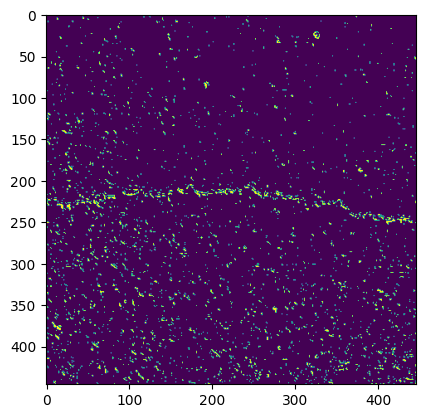

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

'''here the grad cam is implemented'''
def grad_cam(model, img, last_conv_layer_name="conv2d_1", output_layer_name="dense_3"):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [
            model.get_layer(last_conv_layer_name).output,
            model.get_layer(output_layer_name).output
        ]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img.reshape(-1, 448, 448, 3))
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    pooled_grads = tf.reshape(pooled_grads, (1, 1, -1))
    conv_outputs = conv_outputs[0]
    weighted_conv_outputs = conv_outputs * pooled_grads
    heatmap = tf.reduce_sum(weighted_conv_outputs, axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

'''the displaying function'''
def display_grad_cam(heatmap):

    heatmap = np.uint8(255 * heatmap)
    heatmap = tf.keras.preprocessing.image.array_to_img(heatmap)
    heatmap = heatmap.resize((448, 448))
    heatmap = np.array(heatmap)

    plt.axis('off')
    plt.imshow(heatmap)
    plt.show()


sample_input = tf.random.normal([1, 448, 448, 3])
_ = classification_model(sample_input)
test_ds = dataset.get_dataset(split='test', batch_size=1, task='classification')
iterator = test_ds.as_numpy_iterator()
for _ in range(14):
    img, mask = next(iterator)
print(img.shape)
heatmap = grad_cam(classification_model, img.reshape(-1, 448, 448, 3), "conv2d_1", "dense_3")
int_img = (heatmap * 255).astype(np.uint8)
'''otsu thresholding on the heatmap gradient output, to binarize properly the data'''
_, result = cv2.threshold(int_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(result)
bin_result = result*255

### Binary output

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
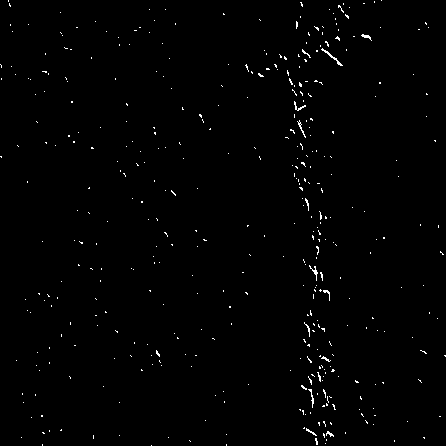

In [ ]:
result*255

In [ ]:
import random as rand
def display_grad_cam_results(model, dataset, grad_cam_function, n=5,
                             last_conv_layer_name="conv2d_1",
                             output_layer_name="dense_3"):
    """
    Display Grad-CAM results alongside original image and mask.

    Args:
    - model: Trained classification model.
    - dataset: Dataset containing image and mask pairs.
    - grad_cam_function: Function to compute Grad-CAM heatmap.
    - n: Number of samples to display.
    - last_conv_layer_name: Name of the last convolutional layer.
    - output_layer_name: Name of the final output layer.

    Returns:
    - None. Displays images and masks in rows.
    """
    sample_input = tf.random.normal([1, 448, 448, 3])
_ = classification_model(sample_input)

    test_ds = dataset.get_dataset(split='test', batch_size=1, task='classification')
    iterator = test_ds.as_numpy_iterator()
    rand_list = [rand.randint(0,1600) for i in range(n)]
    rand_list.sort()
    plt.figure(figsize=(20, 5 * n))
    idx = 0
    for i in range(rand_list[-1]):
        img, mask = next(iterator)
        if i in rand_list:



          heatmap = grad_cam_function(
              model,
              img.reshape(-1, 448, 448, 3),
              last_conv_layer_name,
              output_layer_name
          )
          int_img = (heatmap * 255).astype(np.uint8)

          # Apply Otsu thresholding
          _, bin_result = cv2.threshold(int_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

          # Plot Original Image
          plt.subplot(n, 4, 4 * idx + 1)
          plt.imshow(img.squeeze())  # Assuming RGB or grayscale
          plt.title("Original Image")
          plt.axis('off')

          # Plot Ground Truth Mask
          plt.subplot(n, 4, 4 * idx + 2)
          plt.imshow(mask.squeeze(), cmap='gray')
          plt.title("Original Mask")
          plt.axis('off')

          # Plot Grad-CAM Result
          plt.subplot(n, 4, 4 * idx + 3)
          plt.imshow(int_img, cmap='jet')
          plt.title("Grad-CAM Heatmap")
          plt.axis('off')

          # Plot Binarized Grad-CAM Result
          plt.subplot(n, 4, 4 * idx + 4)
          plt.imshow(bin_result, cmap='gray')
          plt.title("Binarized Heatmap")
          plt.axis('off')

          idx +=1

    plt.tight_layout()
    plt.show()

In [ ]:
def compute_metrics(y_true, y_pred):
    """
    Compute precision and recall for both classes.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    precision_1 = precision_score(y_true_flat, y_pred_flat, pos_label=1, zero_division=0)
    recall_1 = recall_score(y_true_flat, y_pred_flat, pos_label=1, zero_division=0)
    precision_0 = precision_score(y_true_flat, y_pred_flat, pos_label=0, zero_division=0)
    recall_0 = recall_score(y_true_flat, y_pred_flat, pos_label=0, zero_division=0)

    return precision_0, recall_0, precision_1, recall_1

# Loop through the test dataset
test_ds = dataset.get_dataset(split='test', batch_size=1, task='classification')
iterator = test_ds.as_numpy_iterator()

all_precisions_0 = []
all_recalls_0 = []
all_precisions_1 = []
all_recalls_1 = []

num_samples = int(len(iterator) / 10)  # Evaluate on 10% of the test set or a small subset

for _ in range(num_samples):
    img, mask = next(iterator)  # Get image and ground truth mask

    # Predict using the classification model
    prediction = classification_model.predict(img.reshape(-1, 448, 448, 3))
    if prediction[0] < 0.5:
        # Model predicts background class
        binary_pred = np.zeros_like(mask)  # Create a mask with all background pixels
    else:
        # Compute Grad-CAM heatmap
        heatmap = grad_cam(classification_model, img.reshape(-1, 448, 448, 3), "conv2d_1", "dense_3")
        int_img = (heatmap * 255).astype(np.uint8)

        # Apply Otsu thresholding
        _, binary_pred = cv2.threshold(int_img, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Compute metrics for this sample
    precision_0, recall_0, precision_1, recall_1 = compute_metrics(mask, binary_pred)

    # Append to lists
    all_precisions_0.append(precision_0)
    all_recalls_0.append(recall_0)
    all_precisions_1.append(precision_1)
    all_recalls_1.append(recall_1)

# Average metrics over the evaluated samples
avg_precision_0 = np.mean(all_precisions_0)
avg_recall_0 = np.mean(all_recalls_0)
avg_precision_1 = np.mean(all_precisions_1)
avg_recall_1 = np.mean(all_recalls_1)

# Print the final metrics
print("Average Metrics over Test Subset:")
print(f"Class 0 Precision: {avg_precision_0:.4f}")
print(f"Class 0 Recall: {avg_recall_0:.4f}")
print(f"Class 1 Precision: {avg_precision_1:.4f}")
print(f"Class 1 Recall: {avg_recall_1:.4f}")


### Conclusions

The model does not work good in terms of the accuracy and recall metrics  , that's clear from the evaluation, however to the human eye the predicted masks does not look that bad, the crack pixels can be clearly delineated on the predicted mask. The issue with the metrics is that the predicted crack masks  are not smooth and continous as they should be ,rather very fragmented, the gradient was not identical inside whole crack. Another, even bigger issue,  is the background noise, likely casued by the sharp edges and structure of the background elements. Both the issues could be mitigated with the help of the morphologic operations , for example dilation and opening, however this may be too domain specific to this case and could not perform equally good in other applications,  what was the requirement of the task.